In [1]:
using DynamicalSystems, Plots, StatsBase, LaTeXStrings, Distributions, Statistics
include("../src/KoopmanCausality.jl")
using .KoopmanCausality

# Symmetric confounder

![confounder-motif](../images/confounder-motif.png)

In [2]:
function roessler_confounder(u,p,t)
    ω1, ω2, ω3, a, b, c, k12, k13 = p

    du1 = -ω1*u[2] - u[3]
    du2 = ω1*u[1] + a*u[2] 
    du3 = b + u[3]*(u[1]-c)
    
    du4 = -ω2*u[5] - u[6]
    du5 = ω2*u[4] + a*u[5] + k12*(u[2]-u[5])
    du6 = b + u[6]*(u[4]-c)
    
    du7 = -ω3*u[8] - u[9]
    du8 = ω3*u[7] + a*u[8] + k13*(u[2]-u[8])
    du9 = b + u[9]*(u[7]-c)
    return SVector(du1,du2,du3,du4,du5,du6,du7,du8,du9)
end

roessler_confounder (generic function with 1 method)

### Confounding variable, $\omega_1$, induces spurrious correlation between $\omega_2$ and $\omega_3$

In [3]:
ω1 = 0.8
ω2 = 0.5
ω3 = 0.5
a = 0.2
b = 0.2
c = 5.3
k12 = 0.2
k13 = 0.5

times = 50:5:5_000
L = length(times)
x_12_cors = Vector{Float64}(undef, L)
y_12_cors = Vector{Float64}(undef, L)
x_13_cors = Vector{Float64}(undef, L)
y_13_cors = Vector{Float64}(undef, L)
x_23_cors = Vector{Float64}(undef, L)
y_23_cors = Vector{Float64}(undef, L)

u0=[1, -2, 0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]
p = (ω1,ω2,ω3,a,b,c,k12,k13)
ds = CoupledODEs(roessler_confounder, u0, p)
time_step = 0.01
transient_time = 500.0

for (n, time_evolve) in enumerate(times)
    orbit, t = trajectory(ds, time_evolve; Δt=time_step, Ttr=transient_time)
    data = permutedims(Matrix(orbit))
    x_12_cors[n] = cor(data[1, :], data[4, :])
    y_12_cors[n] = cor(data[2, :], data[5, :])
    x_13_cors[n] = cor(data[1, :], data[7, :])
    y_13_cors[n] = cor(data[2, :], data[8, :])
    x_23_cors[n] = cor(data[4, :], data[7, :])
    y_23_cors[n] = cor(data[5, :], data[8, :]) 
end

### Correlations as a function of window size used to collect stats

between $\omega_1$ and $\omega_2$

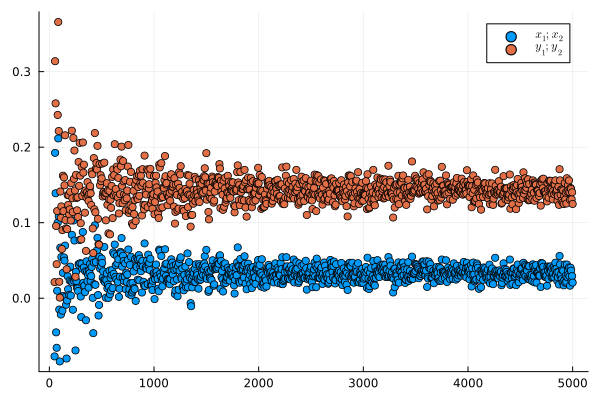

In [11]:
Plots.scatter(times, x_12_cors; label=L"x_1 ; x_2")
Plots.scatter!(times, y_12_cors; label=L"y_1 ; y_2")

between $\omega_1$ and $\omega_3$

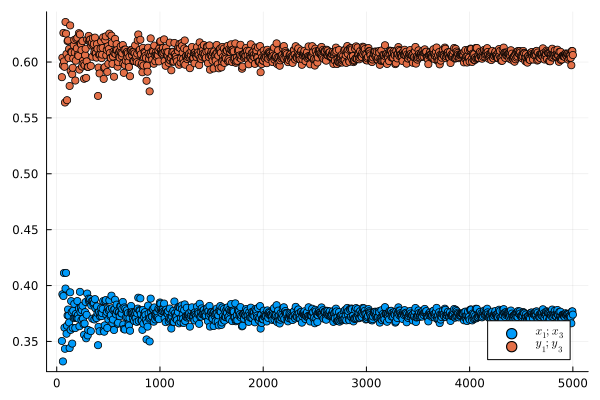

In [12]:
Plots.scatter(times, x_13_cors; label=L"x_1 ; x_3")
Plots.scatter!(times, y_13_cors; label=L"y_1 ; y_3")

spurrious correlations between $\omega_2$ and $\omega_3$ 

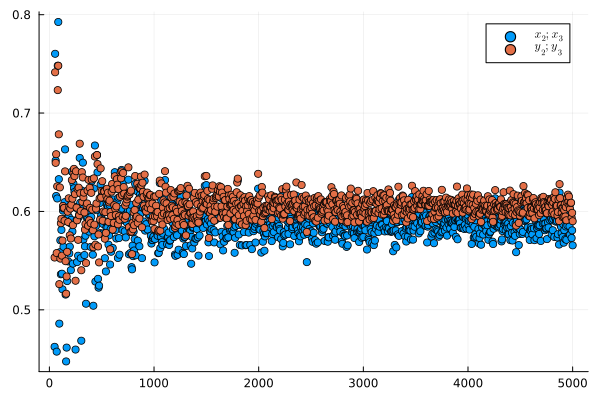

In [13]:
Plots.scatter(times, x_23_cors; label=L"x_2 ; x_3")
Plots.scatter!(times, y_23_cors; label=L"y_2 ; y_3")

To further demonstrate, turn off coupling between $\omega_1$ and $\omega_2$ to remove confounding between, and thus decorrelate, $\omega_2$ and $\omega_3$

In [ ]:
ω1 = 0.8
ω2 = 0.5
ω3 = 0.5
a = 0.2
b = 0.2
c = 5.3
k13 = 0.5

k12 = 0.0 # turn off coupling between 1,2

times = 50:5:5_000
L = length(times)
x_23_cors = Vector{Float64}(undef, L)
y_23_cors = Vector{Float64}(undef, L)

u0=[1, -2, 0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]
p = (ω1,ω2,ω3,a,b,c,k12,k13)
ds = CoupledODEs(roessler_confounder, u0, p)
time_step = 0.01
transient_time = 500.0

for (n, time_evolve) in enumerate(times)
    orbit, t = trajectory(ds, time_evolve; Δt=time_step, Ttr=transient_time)
    data = permutedims(Matrix(orbit))
    x_23_cors[n] = cor(data[4, :], data[7, :])
    y_23_cors[n] = cor(data[5, :], data[8, :]) 
end

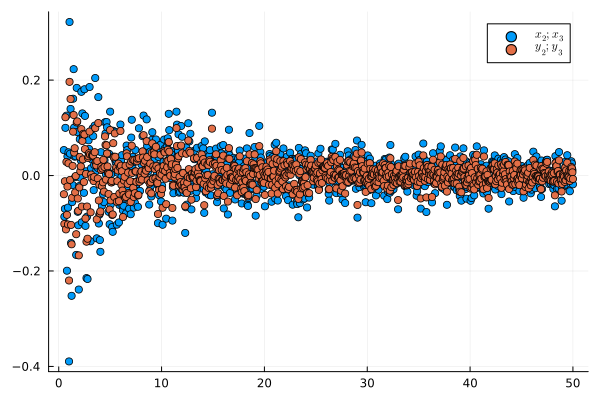

In [16]:
Plots.scatter(times.*time_step, x_23_cors; label=L"x_2 ; x_3")
Plots.scatter!(times.*time_step, y_23_cors; label=L"y_2 ; y_3")

## Koopman causality for symmetrically-coupled Rossler confounder

In [3]:
ω1 = 0.8
ω2 = 0.5
ω3 = 0.5
a = 0.2
b = 0.2
c = 5.3
k12 = 0.5
k13 = 0.5

u0=[1, -2, 0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]
p = (ω1,ω2,ω3,a,b,c,k12,k13)
ds = CoupledODEs(roessler_confounder, u0, p)
T_evolve = 8_000.0
time_step = 0.01
transient_time = 1_000.0
orbit, t = trajectory(ds, T_evolve; Δt=time_step, Ttr=transient_time)
data = permutedims(Matrix(orbit))
T = size(data, 2)

800001

In [4]:
# Δ = 500
Δ = 1_000
split = 20_000

Xtot = Array{Float32}(undef, 9, T-Δ)
Ytot = Array{Float32}(undef, 9, T-Δ)

for t in 1:(T-Δ)
    Xtot[:, t] = data[:, t]
    Ytot[:, t] = data[:, t+Δ]
end

X = Xtot[:, 1:end-split]
Y = Ytot[:, 1:end-split]
Xtest = Xtot[:, end-split+1:end]
Ytest = Ytot[:, end-split+1:end];

In [5]:
Nfeats = 150
σs = [2.0, 1.0, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
# σs = rand(12)
N_samples = 5;

1 -> 2

In [6]:
@time begin 
    Xe = X[4:6, :]
    Ye = Y[4:6, :]
    Xteste = Xtest[4:6, :]
    Yteste = Ytest[4:6, :]

    Xc = X[1:3, :]
    Yc = Y[1:3, :]
    Xtestc = Xtest[1:3, :]
    Ytestc = Ytest[1:3, :]

    kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
    L"\omega_1 \rightarrow \omega_2: \; %$kcause"
end

631.403364 seconds (4.76 M allocations: 272.188 GiB, 1.38% gc time, 0.15% compilation time)


L"$\omega_1 \rightarrow \omega_2: \; 1.2811868310747596$"

1 -> 3

In [7]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[1:3, :]
Yc = Y[1:3, :]
Xtestc = Xtest[1:3, :]
Ytestc = Ytest[1:3, :];

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_1 \rightarrow \omega_3: \; %$kcause"

L"$\omega_1 \rightarrow \omega_3: \; 1.2695345385136412$"

2 -> 3

In [8]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[4:6, :]
Yc = Y[4:6, :]
Xtestc = Xtest[4:6, :]
Ytestc = Ytest[4:6, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_2 \rightarrow \omega_3: \; %$kcause"

L"$\omega_2 \rightarrow \omega_3: \; -0.039853029697048736$"

3 -> 2

In [9]:
Xe = X[4:6, :]
Ye = Y[4:6, :]
Xteste = Xtest[4:6, :]
Yteste = Ytest[4:6, :]

Xc = X[7:end, :]
Yc = Y[7:end, :]
Xtestc = Xtest[7:end, :]
Ytestc = Ytest[7:end, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_3 \rightarrow \omega_2: \; %$kcause"

L"$\omega_3 \rightarrow \omega_2: \; -0.02844991391550411$"

## Koopman causality for asymmetrically-coupled confounder

In [3]:
ω1 = 0.8
ω2 = 0.5
ω3 = 0.5
a = 0.2
b = 0.2
c = 5.3
k12 = 0.5
k13 = 0.3

u0=[1, -2, 0, 0.11, 0.2, 0.1, -0.11, 0.3, 0.0]
p = (ω1,ω2,ω3,a,b,c,k12,k13)
ds = CoupledODEs(roessler_confounder, u0, p)
T_evolve = 8_000.0
time_step = 0.01
transient_time = 1_000.0
orbit, t = trajectory(ds, T_evolve; Δt=time_step, Ttr=transient_time)
data = permutedims(Matrix(orbit))
T = size(data, 2)

800001

In [4]:
Δ = 1_000
split = 20_000

Xtot = Array{Float32}(undef, 9, T-Δ)
Ytot = Array{Float32}(undef, 9, T-Δ)

for t in 1:(T-Δ)
    Xtot[:, t] = data[:, t]
    Ytot[:, t] = data[:, t+Δ]
end

X = Xtot[:, 1:end-split]
Y = Ytot[:, 1:end-split]
Xtest = Xtot[:, end-split+1:end]
Ytest = Ytot[:, end-split+1:end];

In [5]:
Nfeats = 150
σs = [2.0, 1.0, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
N_samples = 5;

1 -> 2

In [6]:
@time begin 
    Xe = X[4:6, :]
    Ye = Y[4:6, :]
    Xteste = Xtest[4:6, :]
    Yteste = Ytest[4:6, :]

    Xc = X[1:3, :]
    Yc = Y[1:3, :]
    Xtestc = Xtest[1:3, :]
    Ytestc = Ytest[1:3, :]

    kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
    L"\omega_1 \rightarrow \omega_2: \; %$kcause"
end

586.363563 seconds (4.76 M allocations: 272.187 GiB, 1.40% gc time, 0.14% compilation time)


L"$\omega_1 \rightarrow \omega_2: \; 1.932267596210068$"

1 -> 3

In [7]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[1:3, :]
Yc = Y[1:3, :]
Xtestc = Xtest[1:3, :]
Ytestc = Ytest[1:3, :];

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_1 \rightarrow \omega_3: \; %$kcause"

L"$\omega_1 \rightarrow \omega_3: \; 2.6199216370489777$"

2 -> 3

In [8]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[4:6, :]
Yc = Y[4:6, :]
Xtestc = Xtest[4:6, :]
Ytestc = Ytest[4:6, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_2 \rightarrow \omega_3: \; %$kcause"

L"$\omega_2 \rightarrow \omega_3: \; 1.4735034034481254$"

3 -> 2

In [9]:
Xe = X[4:6, :]
Ye = Y[4:6, :]
Xteste = Xtest[4:6, :]
Yteste = Ytest[4:6, :]

Xc = X[7:end, :]
Yc = Y[7:end, :]
Xtestc = Xtest[7:end, :]
Ytestc = Ytest[7:end, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_3 \rightarrow \omega_2: \; %$kcause"

L"$\omega_3 \rightarrow \omega_2: \; 0.2787344493487547$"

### Accounting for confounding

$\omega_3$ as cause component

1 -> 3

In [ ]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[1:3, :]
Yc = Y[1:3, :]
Xtestc = Xtest[1:3, :]
Ytestc = Ytest[1:3, :];

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_1 \rightarrow \omega_3: \; %$kcause"

L"$\omega_1 \rightarrow \omega_3: \; 2.6199216370489777$"

[1,2] -> 3

In [10]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[1:6, :]
Yc = Y[1:6, :]
Xtestc = Xtest[1:6, :]
Ytestc = Ytest[1:6, :]

RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)

2.5937777282030523

2 -> 3

In [ ]:
Xe = X[7:end, :]
Ye = Y[7:end, :]
Xteste = Xtest[7:end, :]
Yteste = Ytest[7:end, :]

Xc = X[4:6, :]
Yc = Y[4:6, :]
Xtestc = Xtest[4:6, :]
Ytestc = Ytest[4:6, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_2 \rightarrow \omega_3: \; %$kcause"

L"$\omega_2 \rightarrow \omega_3: \; 1.4735034034481254$"

$\omega_2$ as cause component

1 -> 2

In [ ]:
@time begin 
    Xe = X[4:6, :]
    Ye = Y[4:6, :]
    Xteste = Xtest[4:6, :]
    Yteste = Ytest[4:6, :]

    Xc = X[1:3, :]
    Yc = Y[1:3, :]
    Xtestc = Xtest[1:3, :]
    Ytestc = Ytest[1:3, :]

    kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
    L"\omega_1 \rightarrow \omega_2: \; %$kcause"
end

586.363563 seconds (4.76 M allocations: 272.187 GiB, 1.40% gc time, 0.14% compilation time)


L"$\omega_1 \rightarrow \omega_2: \; 1.932267596210068$"

[1,3] -> 2

In [11]:
Xe = X[4:6, :]
Ye = Y[4:6, :]
Xteste = Xtest[4:6, :]
Yteste = Ytest[4:6, :]

Xc = vcat(X[1:3, :], X[7:end, :])
Yc = vcat(Y[1:3, :], Y[7:end, :])
Xtestc = vcat(Xtest[1:3, :], Xtest[7:end, :])
Ytestc = vcat(Ytest[1:3, :], Ytest[7:end, :])

RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)

1.8346766108452888

3 -> 2

In [ ]:
Xe = X[4:6, :]
Ye = Y[4:6, :]
Xteste = Xtest[4:6, :]
Yteste = Ytest[4:6, :]

Xc = X[7:end, :]
Yc = Y[7:end, :]
Xtestc = Xtest[7:end, :]
Ytestc = Ytest[7:end, :]

kcause = RFF_koopman_causality(Xe, Xc, Ye, Xteste, Xtestc, Yteste, Nfeats, σs, N_samples)
L"\omega_3 \rightarrow \omega_2: \; %$kcause"

L"$\omega_3 \rightarrow \omega_2: \; 0.2787344493487547$"